In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.tabular.all import *

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# Import the datasets
path = Path('/kaggle/input/spaceship-titanic')
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

In [3]:
# View the data
train_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


# Tidy the Data

In [5]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [6]:
# Name means nothing for this analysis
train_df= train_df.drop(['Name'],axis=1)
test_df= test_df.drop(['Name'],axis=1)

In [7]:
# If null then make them 0 as they spent nothing.
def fill_billed_with_zero(df):
    df['RoomService'] = df.RoomService.fillna(0)
    df['FoodCourt'] = df.FoodCourt.fillna(0)
    df['ShoppingMall'] = df.ShoppingMall.fillna(0)
    df['Spa'] = df.Spa.fillna(0)
    df['VRDeck'] = df.VRDeck.fillna(0)
    
fill_billed_with_zero(train_df)
fill_billed_with_zero(test_df)

In [8]:
# The spends can vary massively so log them to stop them overpowering the model
def log_service_charges(df):
    df['RoomService'] = np.log(df.RoomService, out=np.zeros_like(df.RoomService), where=(df.RoomService!=0))
    df['FoodCourt'] = np.log(df.FoodCourt, out=np.zeros_like(df.FoodCourt), where=(df.FoodCourt!=0))
    df['ShoppingMall'] = np.log(df.ShoppingMall, out=np.zeros_like(df.ShoppingMall), where=(df.ShoppingMall!=0))
    df['Spa'] = np.log(df.Spa, out=np.zeros_like(df.Spa), where=(df.Spa!=0))
    df['VRDeck'] = np.log(df.VRDeck, out=np.zeros_like(df.VRDeck), where=(df.VRDeck!=0))
    
log_service_charges(train_df)
log_service_charges(test_df)

In [9]:
# If not True for VIP & CryoSleep then default to a none VIP and none CryoSleep
def fill_vip_and_cryo_with_false(df):
    df['VIP'] = df.VIP.fillna(False)
    df['CryoSleep'] = df.CryoSleep.fillna(False)
    
fill_vip_and_cryo_with_false(train_df)
fill_vip_and_cryo_with_false(test_df)

In [10]:
# To fill in the missing ages then we should look for a suitable grouping for median (rather than just default a median of everything)
df_corr = train_df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr[df_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
1,Age,Age,1.000000
36,Age,FoodCourt,0.196247
38,Age,Spa,0.181910
42,Age,VRDeck,0.163527
52,Age,RoomService,0.117602
56,Age,ShoppingMall,0.092479
57,Age,VIP,0.091822
71,Age,Transported,0.075026
74,Age,CryoSleep,0.071585


In [11]:
# No correlation, so default age to median
def fill_age_with_median(df):
    df['Age'] = df.Age.fillna(df.Age.median())
    
fill_age_with_median(train_df)
fill_age_with_median(test_df)

## What are suitable replacements for missing values in?
* HomePlanet
* Cabin
* Destination

In [12]:
# If it's not known then that tells us something, so best to fill with an "unknown" value?
def fill_hp_cabin_dest_with_unknown(df):
    df['HomePlanet'] = df.HomePlanet.fillna('Unknown')
    df['Cabin'] = df.Cabin.fillna('Unknown')
    df['Destination'] = df.Destination.fillna('Unknown')
    
fill_hp_cabin_dest_with_unknown(train_df)
fill_hp_cabin_dest_with_unknown(test_df)

In [13]:
# Should now have no missing values
train_df.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

## Interesting Data
### PassengerId
A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

*Splitting out the group to a new column could show something interesting*

### Cabin
The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

*Splitting deck and side out as it's own value could show something*

In [14]:
# Create the Group ID column
def create_group_id(df):
    df['GroupId'] = df.PassengerId.apply(lambda s: s[:4])
    
create_group_id(train_df)
create_group_id(test_df)

In [15]:
# Create the Deck Column
def create_deck(df):
    df['Deck'] = df.Cabin.apply(lambda s: s[:1])
    
create_deck(train_df)
create_deck(test_df)

In [16]:
# Create the Side Column (unknown will get the value N so they are together still)
def create_side(df):
    df['Side'] = df.Cabin.apply(lambda s: s[-1])
    
create_side(train_df)
create_side(test_df)

In [17]:
# View the data again to check the changes
train_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,Deck,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,False,0001,B,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,4.691348,2.197225,3.218876,6.308098,3.784190,True,0002,F,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,3.761200,8.182000,0.000000,8.812099,3.891820,False,0003,A,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.000000,7.156956,5.916202,8.110427,5.262690,False,0003,A,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,5.713733,4.248495,5.017280,6.336826,0.693147,True,0004,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.000000,8.827468,0.000000,7.404279,4.304065,False,9276,A,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,False,9278,G,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.000000,0.000000,7.534763,0.000000,0.000000,True,9279,G,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.000000,6.955593,0.000000,5.866468,8.081784,False,9280,E,S


# Create the Model

In [18]:
dls = TabularDataLoaders.from_df(train_df, y_names="Transported", y_block = CategoryBlock(),
    cat_names = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'GroupId', 'Deck', 'Side'],
    cont_names = ['Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
    procs = [Categorify, Normalize])

In [19]:
dls.show_batch()

,HomePlanet,CryoSleep,Cabin,Destination,GroupId,Deck,Side,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,True,B/213/P,55 Cancri e,6263,B,P,17.000000,-4.131217e-10,-3.294005e-08,-9.619967e-09,-5.967238e-09,4.660081e-08,4.727571e-09,True
1,Unknown,True,G/690/S,TRAPPIST-1e,4212,G,S,28.000000,-4.131217e-10,-3.294005e-08,-9.619967e-09,-5.967238e-09,4.660081e-08,4.727571e-09,True
2,Europa,True,C/151/S,55 Cancri e,4210,C,S,50.000000,-4.131217e-10,-3.294005e-08,-9.619967e-09,-5.967238e-09,4.660081e-08,4.727571e-09,True
3,Earth,False,E/260/P,TRAPPIST-1e,4168,E,P,28.000000,-4.131217e-10,-3.294005e-08,5.484797e+00,1.791759e+00,4.660081e-08,6.295266e+00,False
4,Europa,False,C/218/P,55 Cancri e,6853,C,P,31.000000,-4.131217e-10,-3.294005e-08,7.380256e+00,8.308446e+00,8.317278e+00,4.820281e+00,False
5,Mars,False,D/42/P,TRAPPIST-1e,1093,D,P,23.000000,-4.131217e-10,7.529407e+00,4.077538e+00,2.890372e+00,5.257495e+00,4.727571e-09,True
6,Earth,True,G/558/S,PSO J318.5-22,3456,G,S,16.000000,-4.131217e-10,-3.294005e-08,-9.619967e-09,-5.967238e-09,4.660081e-08,4.727571e-09,True
7,Europa,False,B/40/P,TRAPPIST-1e,1123,B,P,28.000000,-4.131217e-10,-3.294005e-08,5.996452e+00,-5.967238e-09,4.905275e+00,9.106090e+00,False
8,Earth,True,G/1023/S,TRAPPIST-1e,6309,G,S,3.000001,-4.131217e-10,-3.294005e-08,-9.619967e-09,-5.967238e-09,4.660081e-08,4.727571e-09,True
9,Earth,False,E/594/S,PSO J318.5-22,9078,E,S,44.000000,-4.131217e-10,-3.294005e-08,6.931472e-01,-5.967238e-09,4.660081e-08,7.349874e+00,False


In [20]:
learn = tabular_learner(dls, metrics=accuracy, layers=[300, 200, 100, 50, 10])

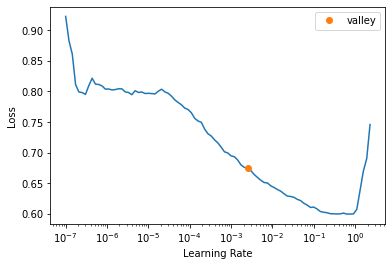

In [21]:
# Find a good learning rate
suggested_lr = learn.lr_find()

In [22]:
learn.fit_one_cycle(20, suggested_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.522266,0.479201,0.776755,00:04
1,0.442489,0.504672,0.776179,00:03
2,0.312307,0.548250,0.734177,00:03
3,0.210771,0.619407,0.776755,00:03
4,0.162536,0.655667,0.765247,00:03
5,0.130543,0.629216,0.769850,00:03
6,0.116119,0.724153,0.771001,00:03
7,0.110572,0.686317,0.779632,00:03
8,0.084070,0.738524,0.772727,00:03
9,0.075860,0.767095,0.778481,00:03


In [23]:
learn.show_results()

,HomePlanet,CryoSleep,Cabin,Destination,GroupId,Deck,Side,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Transported_pred
0,1.0,2.0,4623.0,3.0,4317.0,7.0,2.0,0.862877,-0.15924,-0.631082,-0.642597,-0.616695,-0.652330,-0.632729,1.0,1.0
1,2.0,1.0,737.0,3.0,4182.0,3.0,1.0,0.514267,-0.15924,-0.631082,2.032131,2.252083,2.213987,-0.632729,0.0,0.0
2,1.0,1.0,5225.0,2.0,6078.0,7.0,2.0,-0.113229,-0.15924,-0.631082,1.446393,-0.616695,0.820202,1.454173,0.0,0.0
3,1.0,1.0,4592.0,3.0,4248.0,7.0,2.0,-0.531560,-0.15924,-0.631082,-0.642597,0.672885,1.597701,1.407750,1.0,0.0
4,2.0,2.0,311.0,3.0,341.0,2.0,2.0,1.490373,-0.15924,-0.631082,-0.642597,-0.616695,-0.652330,-0.632729,1.0,1.0
5,3.0,1.0,1240.0,1.0,474.0,4.0,2.0,-0.322395,-0.15924,2.275858,-0.642597,1.591986,0.098624,-0.046903,0.0,0.0
6,1.0,2.0,4596.0,2.0,4276.0,7.0,1.0,-1.856275,-0.15924,-0.631082,-0.642597,-0.616695,-0.652330,-0.632729,0.0,1.0
7,3.0,1.0,1693.0,3.0,3034.0,5.0,2.0,0.374824,-0.15924,1.850426,0.693271,1.677056,-0.652330,0.524064,0.0,0.0
8,3.0,1.0,1095.0,1.0,2864.0,4.0,2.0,1.908704,-0.15924,1.584382,1.463384,0.233642,1.067447,0.639979,1.0,1.0


Notes on Layers from playing around:
* [10, 10] with 20 epochs - got to 0.762371
* [10, 10, 10, 10, 10] with 20 epochs - got to 0.768700
* [300, 200, 100, 50, 10] with 20 epochs - got to 0.793441 accuracy

In [24]:
# Run the predictions
tst_dl = learn.dls.test_dl(test_df)
preds,_ = learn.get_preds(dl=tst_dl)

In [25]:
# Create the submission file
test_df['Transported'] = (preds[:,1]>0.5)
sub_df = test_df[['PassengerId','Transported']]

In [26]:
sub_df.to_csv('submission.csv', index=False)